In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
TRAIN_SIZE = 1000000
TEST_SIZE = 100
SAMPLE_SIZE = 100
LOWER_PARAM_BOUND = 0.1
UPPER_PARAM_BOUND = 10
TRAIN_ITERS = TRAIN_SIZE
BATCH_SIZE = 10

LAYERS_NUM = 3
INPUT_SIZE = 4
WEIGHT_SIZE = [[INPUT_SIZE, 6], [6, 5], [5, SAMPLE_SIZE]]
BIAS_SIZE = [6, 5, SAMPLE_SIZE]

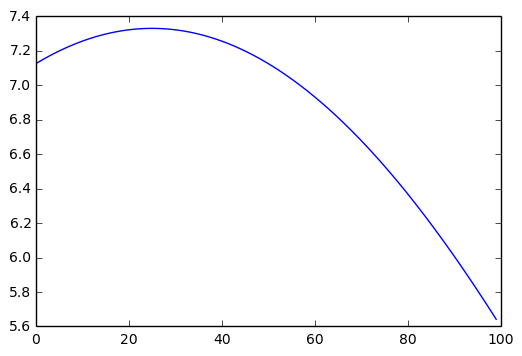

In [3]:
def super_sin(a, b, c, d):
    def _sin(x):
        return (d * np.sin(a * x + b) + c)
    return _sin

def generate_sample(sample_size, fn):
    x = np.linspace(0, 2*3.1415, sample_size)
    y = fn(x)
    return np.array(y)

def generate_set(set_size, sample_size, lower_param_bound, upper_param_bound):
    X = []
    Y = []
    for _ in xrange(set_size):
        param = [np.random.uniform(lower_param_bound, upper_param_bound) for _ in xrange(4)]
        X.append(np.array(param))
        Y.append(generate_sample(sample_size, super_sin(*param)))
    return np.array(X), np.array(Y)

X_train, y_train = generate_set(TRAIN_SIZE, SAMPLE_SIZE, LOWER_PARAM_BOUND, UPPER_PARAM_BOUND)
X_test, y_test = generate_set(TEST_SIZE, SAMPLE_SIZE, LOWER_PARAM_BOUND, UPPER_PARAM_BOUND)
plt.plot(y_train[0])

In [4]:
def mlp(input, output_dim):
    w1=tf.get_variable("w0", [input.get_shape()[1], 6], initializer=tf.random_normal_initializer())
    b1=tf.get_variable("b0", [6], initializer=tf.constant_initializer(0.0))
    w2=tf.get_variable("w1", [6, 5], initializer=tf.random_normal_initializer())
    b2=tf.get_variable("b1", [5], initializer=tf.constant_initializer(0.0))
    w3=tf.get_variable("w2", [5, output_dim], initializer=tf.random_normal_initializer())
    b3=tf.get_variable("b2", [output_dim], initializer=tf.constant_initializer(0.0))
    
    fc1=tf.nn.tanh(tf.matmul(input,w1) + b1)
    fc2=tf.nn.tanh(tf.matmul(fc1,w2) + b2)
    fc3=tf.nn.tanh(tf.matmul(fc2,w3) + b3)
    return fc3, [w1,b1,w2,b2,w3,b3]

In [5]:
def momentum_optimizer(loss, var_list): #разобраться с оптимизатором
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.001,                
        batch,  
        TRAIN_ITERS // 4,
        0.95,                
        staircase=True)
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.6).minimize(loss,global_step = batch, var_list = var_list)
    return optimizer

In [6]:
with tf.variable_scope("G"):
    z_node = tf.placeholder(tf.float32, shape = (BATCH_SIZE, INPUT_SIZE)) #вместо 1 можно подставить batch_size
    G, theta_g = mlp(z_node, SAMPLE_SIZE)
    G = tf.multiply(G, 5.0)
    
with tf.variable_scope("D") as scope:
    x_node=tf.placeholder(tf.float32, shape=(BATCH_SIZE, SAMPLE_SIZE))
    fc, theta_d = mlp(x_node, 1) 
    D1 = tf.maximum(tf.minimum(fc, 0.99), 0.01)
    
    scope.reuse_variables()
    fc, theta_d = mlp(G, 1)
    D2=tf.maximum(tf.minimum(fc,.99), 0.01)
    
obj_d = tf.reduce_mean(tf.square(D1) + tf.square(1 - D2))
obj_g = tf.reduce_mean(tf.square(D2))
 
opt_d = momentum_optimizer(obj_d, theta_d)
opt_g = momentum_optimizer(obj_g, theta_g)

In [7]:
sess = tf.Session()

In [8]:
dis_loss = np.zeros(TRAIN_SIZE/BATCH_SIZE)
gen_loss = np.zeros(TRAIN_SIZE/BATCH_SIZE)
sess.run(tf.global_variables_initializer())
for i in xrange(TRAIN_SIZE/BATCH_SIZE):
    flag = i // 2
    X_batch = X_train[i * BATCH_SIZE:(i + 1) * BATCH_SIZE].reshape((BATCH_SIZE, INPUT_SIZE))
    y_batch = y_train[i * BATCH_SIZE:(i + 1) * BATCH_SIZE].reshape((BATCH_SIZE, SAMPLE_SIZE))
    gen_loss[i], _, _ = sess.run(
                                 [obj_g, opt_d, opt_g], 
                                 feed_dict={z_node: X_batch, x_node: y_batch}
                             )

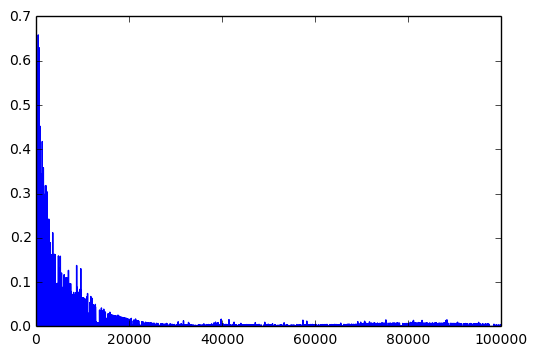

In [9]:
plt.plot(gen_loss)

In [10]:
#plt.plot(range(TRAIN_ITERS), dis_loss, label='discriminator loss')

In [11]:
def plot_fig():
    # plots pg, pdata, decision boundary 
    f,ax=plt.subplots(1)
    # p_data
    ax.plot(y_test[0], label='p_data')

    pred = sess.run(G, feed_dict={z_node: X_test[:10].reshape((BATCH_SIZE, INPUT_SIZE))})
    ax.plot(pred[0].reshape((SAMPLE_SIZE)), label='p_g')

    # ylim, legend
    plt.legend()

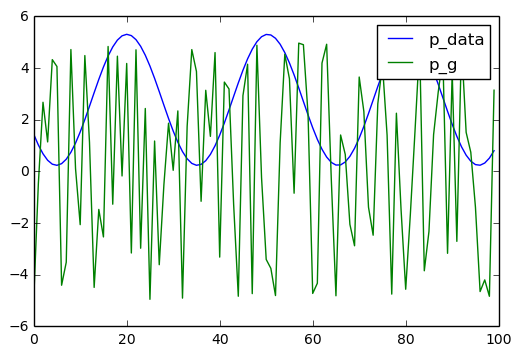

In [12]:
plot_fig()